# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

# learning_rates = [1e-9, 1e-8, 1e-7]
# regularization_strengths = [5e4, 5e5, 5e6]

learning_rates = np.logspace(-9, -7, 5,np.e)
regularization_strengths = np.linspace(5e4, 5e6, 5)

results_svm = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate = lr, reg = reg, num_iters=300)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_acc = np.mean(y_train == y_train_pred)*100
        val_acc = np.mean(y_val == y_val_pred)*100
        results_svm[(lr,reg)] = (train_acc,val_acc)
        if best_val<val_acc:
            best_val = val_acc
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results_svm):
    train_accuracy, val_accuracy = results_svm[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 6.985714 val accuracy: 7.800000
lr 1.000000e-09 reg 1.287500e+06 train accuracy: 8.528571 val accuracy: 6.900000
lr 1.000000e-09 reg 2.525000e+06 train accuracy: 9.483673 val accuracy: 9.600000
lr 1.000000e-09 reg 3.762500e+06 train accuracy: 8.977551 val accuracy: 8.900000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 11.802041 val accuracy: 12.700000
lr 3.162278e-09 reg 5.000000e+04 train accuracy: 11.257143 val accuracy: 12.200000
lr 3.162278e-09 reg 1.287500e+06 train accuracy: 9.004082 val accuracy: 8.000000
lr 3.162278e-09 reg 2.525000e+06 train accuracy: 8.732653 val accuracy: 9.300000
lr 3.162278e-09 reg 3.762500e+06 train accuracy: 11.789796 val accuracy: 12.300000
lr 3.162278e-09 reg 5.000000e+06 train accuracy: 25.522449 val accuracy: 25.100000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 9.104082 val accuracy: 9.800000
lr 1.000000e-08 reg 1.287500e+06 train accuracy: 19.785714 val accuracy: 21.600000
lr 1.000000e-08 re

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.409


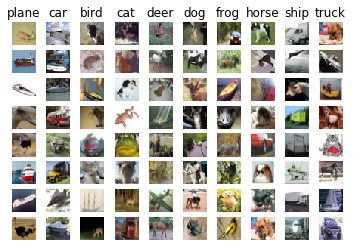

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ They do make some sense, but the network is obviously making many mistakes. It seems reasonable to show birds that it things are planes, but not so much to show ship, truck, or deer... similarly there are trucks, cats, dogs and deer being called horse more than actual horses. 




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
print(X_train.shape,X_train_feats.shape,32*32*3)

(49000, 32, 32, 3) (49000, 154) 3072


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet

results = {}

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_val = 0
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

input_size =input_dim
num_classes = 10
learning_rates = np.logspace(-0.5, 0.5, 5,np.e)
regularization_strengths = np.logspace(-4, -2, 5,np.e)

Ntotal = len(learning_rates)*len(regularization_strengths)#*len(hidden_sizes)
i=0
for lr in learning_rates:
    for reg in regularization_strengths:
#         for hs in hidden_sizes:
            hs = hidden_dim
            i+=1
            print(str(i) + ' out of ' + str(Ntotal) + ' with lr='+str(lr)+' and reg='+str(reg))
            net = TwoLayerNet(input_size,hs,num_classes)
    #         net.train(X_train, y_train, lr, reg, num_iters=1500, verbose=False)
            net.train(X_train_feats, y_train, X_val_feats, y_val,num_iters=1000,batch_size=200,
                                                     learning_rate=lr,learning_rate_decay=0.95,
                                                     reg=reg, verbose=True)
            y_train_pred = net.predict(X_train_feats)
            y_val_pred = net.predict(X_val_feats)
            train_acc = np.mean(y_train == y_train_pred)*100
            val_acc = np.mean(y_val == y_val_pred)*100
            results[(lr,reg)] = (train_acc,val_acc)
            if best_val<val_acc:
                best_val = val_acc
                best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


1 out of 25 with lr=0.31622776601683794 and reg=0.0001
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.812793
iteration 200 / 1000: loss 1.506456
iteration 300 / 1000: loss 1.356756
iteration 400 / 1000: loss 1.280495
iteration 500 / 1000: loss 1.372961
iteration 600 / 1000: loss 1.243638
iteration 700 / 1000: loss 1.273892
iteration 800 / 1000: loss 1.062493
iteration 900 / 1000: loss 1.175037
2 out of 25 with lr=0.31622776601683794 and reg=0.00031622776601683794
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.790537
iteration 200 / 1000: loss 1.412778
iteration 300 / 1000: loss 1.465732
iteration 400 / 1000: loss 1.297376
iteration 500 / 1000: loss 1.257746
iteration 600 / 1000: loss 1.267046
iteration 700 / 1000: loss 1.070229
iteration 800 / 1000: loss 1.350688
iteration 900 / 1000: loss 1.179263
3 out of 25 with lr=0.31622776601683794 and reg=0.001
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 1.833798
iteration 200 / 1000: loss 1.37539

iteration 800 / 1000: loss 1.852544
iteration 900 / 1000: loss 1.828859
21 out of 25 with lr=3.1622776601683795 and reg=0.0001
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.416942
iteration 200 / 1000: loss 1.759814
iteration 300 / 1000: loss 1.815228
iteration 400 / 1000: loss 1.505530
iteration 500 / 1000: loss 1.392066
iteration 600 / 1000: loss 1.515293
iteration 700 / 1000: loss 1.483824
iteration 800 / 1000: loss 1.496222
iteration 900 / 1000: loss 1.185912
22 out of 25 with lr=3.1622776601683795 and reg=0.00031622776601683794
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 1.737031
iteration 200 / 1000: loss 1.720927
iteration 300 / 1000: loss 1.475107
iteration 400 / 1000: loss 1.492209
iteration 500 / 1000: loss 1.639119
iteration 600 / 1000: loss 1.301503
iteration 700 / 1000: loss 1.588208
iteration 800 / 1000: loss 1.464229
iteration 900 / 1000: loss 1.436932
23 out of 25 with lr=3.1622776601683795 and reg=0.001
iteration 0 / 1000: loss 2.30258

In [94]:
# regularization_strengths
# learning_rates

In [95]:
for x in results:
    print(x)

(0.1, 0.0001)
(0.1, 0.0005623413251903491)
(0.1, 0.0031622776601683794)
(0.1, 0.01778279410038923)
(0.1, 0.1)
(0.31622776601683794, 0.0001)
(0.31622776601683794, 0.0005623413251903491)
(0.31622776601683794, 0.0031622776601683794)
(0.31622776601683794, 0.01778279410038923)
(0.31622776601683794, 0.1)
(1.0, 0.0001)
(1.0, 0.0005623413251903491)
(1.0, 0.0031622776601683794)
(1.0, 0.01778279410038923)
(1.0, 0.1)
(3.1622776601683795, 0.0001)
(3.1622776601683795, 0.0005623413251903491)
(3.1622776601683795, 0.0031622776601683794)
(3.1622776601683795, 0.01778279410038923)
(3.1622776601683795, 0.1)
(10.0, 0.0001)
(10.0, 0.0005623413251903491)
(10.0, 0.0031622776601683794)
(10.0, 0.01778279410038923)
(10.0, 0.1)


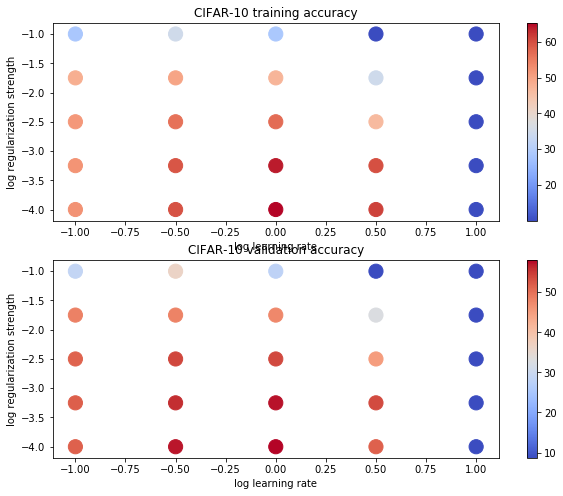

In [99]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 200
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [97]:
best_val,val_acc,best_net

(57.99999999999999,
 8.7,
 <cs231n.classifiers.neural_net.TwoLayerNet at 0x2c481f1ad68>)

In [98]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.529
